#Importações

**Bibliotecas**


In [ ]:
pip install pandera

     |████████████████████████████████| 186 kB 5.4 MB/s 
     |████████████████████████████████| 161 kB 48.4 MB/s 


In [ ]:
pip install fsspec

     |████████████████████████████████| 132 kB 5.3 MB/s 


In [ ]:
pip install gcsfs

     |████████████████████████████████| 1.1 MB 8.1 MB/s 
     |████████████████████████████████| 192 kB 51.5 MB/s 
     |████████████████████████████████| 271 kB 49.7 MB/s 
     |████████████████████████████████| 160 kB 55.0 MB/s 


In [ ]:
from matplotlib import pyplot as plt
from google.cloud import storage
import pandera as pa
import pandas as pd
import numpy as np
import os

**Importando DataFrame**

In [ ]:
df = pd.read_csv(r'gs://projetofinalgrupo8/saida/youtube_data_base.csv')

In [ ]:
df.head(2)

,video_id,title,publishedAt,channelId,channelTitle,trending_date,view_count,likes,dislikes,comment_count,comments_disabled,ratings_disabled,country,json_title
0,s9FH4rDMvds,LEVEI UM FORA? FINGI ESTAR APAIXONADO POR ELA!,2020-08-11T22:21:49Z,UCGfBwrCoi9ZJjKiUK8MmJNw,Pietro Guedes,2020-08-12T00:00:00Z,263835,85095,487,4500,False,False,BR,People & Blogs
1,jbGRowa5tIk,ITZY “Not Shy” M/V TEASER,2020-08-11T15:00:13Z,UCaO6TYtlC8U5ttz62hTrZgg,JYP Entertainment,2020-08-12T00:00:00Z,6000070,714310,15176,31040,False,False,BR,Music


#Exploração dos dados

**Verificando dimensão do DataFrame**

In [ ]:
df.shape

(1021622, 14)

**Tipos dos dados**

In [ ]:
df.dtypes

video_id             object
title                object
publishedAt          object
channelId            object
channelTitle         object
trending_date        object
view_count            int64
likes                 int64
dislikes              int64
comment_count         int64
comments_disabled      bool
ratings_disabled       bool
country              object
json_title           object
dtype: object

#Backup

In [ ]:
df2 = df.copy()

#Renomeando colunas e dados Categoricos

**Criando listas para renomear colunas**

In [ ]:
col_old = ['video_id', 'title', 'publishedAt', 'channelId', 'channelTitle',
       'trending_date', 'view_count', 'likes', 'dislikes', 'comment_count',
       'comments_disabled', 'ratings_disabled', 'country', 'json_title']

col_new = ['id_video', 'titulo_video', 'publicado_em', 'id_canal', 'nome_canal',
           'data_destaque', 'cont_visualizacao', 'curtidas', 'nao_curtidas', 'cont_comentarios',
           'comentarios_desabilitados', 'curtidas_desabilitadas', 'pais', 'categoria']

In [ ]:
df2.columns = col_new

In [ ]:
df2.head(2)

,id_video,titulo_video,publicado_em,id_canal,nome_canal,data_destaque,cont_visualizacao,curtidas,nao_curtidas,cont_comentarios,comentarios_desabilitados,curtidas_desabilitadas,pais,categoria
0,s9FH4rDMvds,LEVEI UM FORA? FINGI ESTAR APAIXONADO POR ELA!,2020-08-11T22:21:49Z,UCGfBwrCoi9ZJjKiUK8MmJNw,Pietro Guedes,2020-08-12T00:00:00Z,263835,85095,487,4500,False,False,BR,People & Blogs
1,jbGRowa5tIk,ITZY “Not Shy” M/V TEASER,2020-08-11T15:00:13Z,UCaO6TYtlC8U5ttz62hTrZgg,JYP Entertainment,2020-08-12T00:00:00Z,6000070,714310,15176,31040,False,False,BR,Music


**Vericando tipos de categorias**

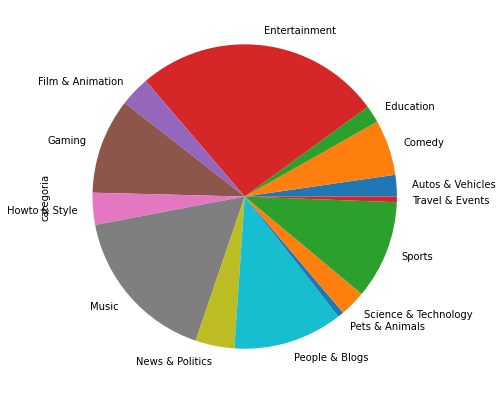

In [ ]:
df2.groupby(["categoria"]).categoria.count().plot.pie(figsize=(12,7))

In [ ]:
df2['categoria'].unique()

array(['People & Blogs', 'Music', 'Gaming', 'Comedy', 'Sports',
       'Entertainment', 'Education', 'Autos & Vehicles', 'Howto & Style',
       'News & Politics', 'Science & Technology', 'Film & Animation',
       'Travel & Events', 'Pets & Animals', nan], dtype=object)

**Criando listas para renomear as categorias**

In [ ]:
categoria_antiga = ['People & Blogs', 'Music', 'Gaming', 'Comedy', 'Sports',
       'Entertainment', 'Education', 'Autos & Vehicles', 'Howto & Style',
       'News & Politics', 'Science & Technology', 'Film & Animation',
       'Travel & Events', 'Pets & Animals']

categoria_nova = ['pessoas_e_blogs', 'musica', 'jogos', 'comedia', 'esportes',
                  'entretenimento', 'educacao', 'automoveis', 'como_faz_e_estilos',
                  'noticias_e_politicas', 'ciencias_e_tecnologia', 'filme_e_animacao',
                  'viagens_e_eventos', 'animais']

**Renomeando categorias**

In [ ]:
df2['categoria'] = df2['categoria'].replace(categoria_antiga, categoria_nova)

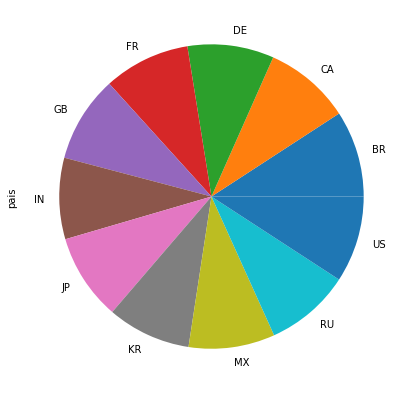

In [ ]:
df2.groupby(["pais"]).pais.count().plot.pie(figsize=(12,7))

#Formatando datetime

**Verificando os tipos de dados do DataFrame**

In [ ]:
df2.dtypes

id_video                     object
titulo_video                 object
publicado_em                 object
id_canal                     object
nome_canal                   object
data_destaque                object
cont_visualizacao             int64
curtidas                      int64
nao_curtidas                  int64
cont_comentarios              int64
comentarios_desabilitados      bool
curtidas_desabilitadas         bool
pais                         object
categoria                    object
dtype: object

In [ ]:
df2['publicado_em'] = pd.to_datetime(df2['publicado_em']).dt.strftime("%Y-%m-%d %H:%M:%S")
df2['publicado_em'] = pd.to_datetime(df2['publicado_em'])

In [ ]:
df2['data_destaque'] = pd.to_datetime(df2['data_destaque']).dt.strftime("%Y-%m-%d")
df2['data_destaque'] = pd.to_datetime(df2['data_destaque'])

In [ ]:
df2.dtypes

In [ ]:
df2.sample()

In [ ]:
df2.groupby(["data_destaque"]).data_destaque.count().plot.line(figsize=(12,7))

#Tratando dados nulos

**Verificando números de dados nulos**

In [ ]:
df2.isna().sum()

**Tratando os valores nulos da coluna "Categoria"**

In [ ]:
categoria_antiga = ['People & Blogs', 'Music', 'Gaming', 'Comedy', 'Sports',
       'Entertainment', 'Education', 'Autos & Vehicles', 'Howto & Style',
       'News & Politics', 'Science & Technology', 'Film & Animation',
       'Travel & Events', 'Pets & Animals', np.nan]

categoria_nova = ['pessoas_e_blogs', 'musica', 'jogos', 'comedia', 'esportes',
                  'entretenimento', 'educacao', 'automoveis', 'como_faz_e_estilos',
                  'noticias_e_politicas', 'ciencias_e_tecnologia', 'filme_e_animacao',
                  'viagens_e_eventos', 'animais', 'outros']

In [ ]:
df2['categoria'] = df2['categoria'].replace(categoria_antiga, categoria_nova)

In [ ]:
df2.isna().sum()

**Verificando nomes de canais com valor nulo**

In [ ]:
df2[df2['nome_canal'].isnull()]

**Removendo linha com nome de canal nulo**

In [ ]:
df2.drop(499155, inplace = True)

In [ ]:
df2.isna().sum()

#Validação dos dados

In [ ]:
df2.dtypes

In [ ]:
schema = pa.DataFrameSchema(
    columns = {
        "id_video":pa.Column(pa.String),
        "titulo_video":pa.Column(pa.String),
        "publicado_em":pa.Column(pa.DateTime),
        "id_canal":pa.Column(pa.String),
        "nome_canal":pa.Column(pa.String),
        "data_destaque":pa.Column(pa.DateTime),
        "cont_visualizacao":pa.Column(pa.Int),
        "curtidas":pa.Column(pa.Int),
        "nao_curtidas":pa.Column(pa.Int),
        "cont_comentarios":pa.Column(pa.Int),
        "comentarios_desabilitados":pa.Column(pa.Bool),
        "curtidas_desabilitadas":pa.Column(pa.Bool),
        "pais":pa.Column(pa.String),
        "categoria":pa.Column(pa.String)
    }
)

In [ ]:
schema.validate(df2)

#Informações gerais sobre os tipo de dados e quantidades de não nulos

In [ ]:
df2.info()

#Exportando DataFrame para o GCP

In [ ]:
from google.cloud import storage
import os
serviceAccount = '/content/projetofinalgrupo8-2dcd866c3f46.json'
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = serviceAccount


client = storage.Client()
bucket = client.get_bucket('projetofinalgrupo8')
    
bucket.blob('saida/youtube_tratado_pandas.csv').upload_from_string(df2.to_csv(index=False), 'text/csv')